# Timeseries of GPM precipitation accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

#### Function to co-locate a landslide event with precipitation

In [2]:
def colocate_to_landslide(glc_df, data_xr, periods=7):
    """
    Returns a dataframe of precipitation values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a precipitation value leading up
        to a landslide event.
        
    Parameters 
    ----------
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
    
    data_xr: xarray.core.dataset.Dataset
        The GPM precipitation data, either single or multi day events
        
    period: int
        Number of periods to generate. Default is 7 days.

    Returns
    -------
    pandas.core.frame.DataFrame 
    """

    gpm_ts_list = []
    for i, date in enumerate(glc_df.index):
        precip = data_xr['precipitationCal'].sel(indexers={
            'time': pd.date_range(date, periods=periods, freq='-1D'),
            'lon': glc_df.longitude[i],
            'lat': glc_df.latitude[i]},
            method="nearest")
        gpm_ts_list.append(precip)
        gpm_ts_list[i]['landslideID'] = glc_df.event_id[i]
        gpm_ts_list[i]['landslideDate'] = date

    gpm_ts_xr = xr.concat(gpm_ts_list,
                          dim='landslideID',
                          fill_value=np.nan,
                          join='override')
    
    return gpm_ts_xr.to_dataframe()

In [3]:
def add_count(df, days):
    """
    Adds a countdown column from N number of days to the Landslide event.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
    days: int
        Where 0 is the landslide event
    
    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """

    cnts = []
    accum = []
    ndays = np.arange(days)+1
    ndays = np.arange(start=-days, stop=0, step=1)
    for i in range(0, int(len(df['precipitationCal'])/days)): 
        cnts.extend(ndays)

    df['days-to-landslide'] = cnts
    return df

#### Calculated the cumulative precipitation

In [4]:
def cumulative_precip(df):
    """
    Add a column of accumulated precipitation
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """
    
    accum = []
    for i, data in df.groupby("landslideID"):
        accum.extend(data['precipitationCal'].cumsum().values)

    df['precip_accum'] = accum
    return df

#### Change directory to where all the Capstone data reside

In [5]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

#### Define the Global Landslide Catalog (GLC)

In [6]:
glc_file = os.path.join('capstone', 'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file) 

True

#### Read and subset to Colorado Landslides

In [7]:
# Read the GLC file
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [8]:
print('The Columns names of the GLC are:')
glc_co.columns

The Columns names of the GLC are:


Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Read the GPM data
- Created from `output_gpm_2007_2016.ipynb` notebook

In [9]:
gpm_nc = os.path.join('capstone', 'gpm', 'gpm_2006-2016_saved_on_disk.nc')
gpm_xr = xr.open_dataset(gpm_nc).squeeze()
print(gpm_xr.dims)
gpm_xr

Frozen({'lon': 76, 'lat': 45, 'time': 3651, 'bnds': 2})


<xarray.Dataset>
Dimensions:                    (lon: 76, lat: 45, time: 3651, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -109.3 -109.2 ... -101.9 -101.8
  * lat                        (lat) float32 36.85 36.95 37.05 ... 41.15 41.25
  * time                       (time) datetime64[ns] 2007-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] ...
    precipitationCal           (time, lon, lat) float32 ...
    precipitationCal_cnt       (time, lon, lat) int8 ...
    precipitationCal_cnt_cond  (time, lon, lat) int8 ...
    HQprecipitation            (time, lon, lat) float32 ...
    HQprecipitation_cnt        (time, lon, lat) int8 ...
    HQprecipitation_cnt_cond   (time, lon, lat) int8 ...
    randomError                (time, lon, lat) float32 ...
    randomError_cnt            (time, lon, lat) int8 ...
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.6
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    ...              ...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-21T13:20:13.605Z
    history_L34RS:   'Created by L34RS v1.4.2 @ NASA GES DISC on April 18 202...
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### Do a demo plot as a sanity check
- <u>NOTE</u> The actual dimensions are `[time, lon, lat]`
- The variable we want is named `precipitationCal`
    - long_name : Daily accumulated precipitation (combined microwave-IR) estimate
    - units : mm

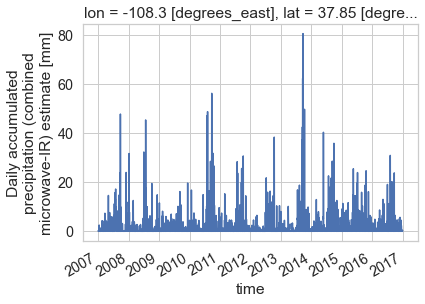

In [10]:
gpm_xr['precipitationCal'][:,10,10].plot()

#### Test the code to match a single co-located Landslide event using nearest neighbor method

In [11]:
test = gpm_xr['precipitationCal'].sel(indexers={'time':glc_co.index[20], 
                  'lon':glc_co.longitude[20],
                  'lat':glc_co.latitude[20]},
                method="nearest")
print(glc_co.index[20], glc_co.longitude[20], glc_co.latitude[20])
test['time'].values, test['lon'].values, test['lat'].values

2010-08-19 15:00:00 -107.2301 39.1905


(numpy.datetime64('2010-08-20T00:00:00.000000000'),
 array(-107.24999, dtype=float32),
 array(39.150005, dtype=float32))

#### Create the DataFrame of co-located Landslides and precipitation for 7, 14, and 30 days

In [12]:
gpm_7days_df = colocate_to_landslide(glc_co, gpm_xr, periods=7)
gpm_14days_df = colocate_to_landslide(glc_co, gpm_xr, periods=14)
gpm_30days_df = colocate_to_landslide(glc_co, gpm_xr, periods=30)

#### Add a count of 30 days of precipitation measurements for each landslide event. This will help in plotting.

In [13]:
gpm_7days_df = add_count(gpm_7days_df, 7)
gpm_14days_df = add_count(gpm_14days_df, 14)
gpm_30days_df = add_count(gpm_30days_df, 30)

#### Add the cumulative column

In [14]:
gpm_7days_df = cumulative_precip(gpm_7days_df)
gpm_14days_df = cumulative_precip(gpm_14days_df)
gpm_30days_df = cumulative_precip(gpm_30days_df)

#### Plot cumulative precip going back 30 days

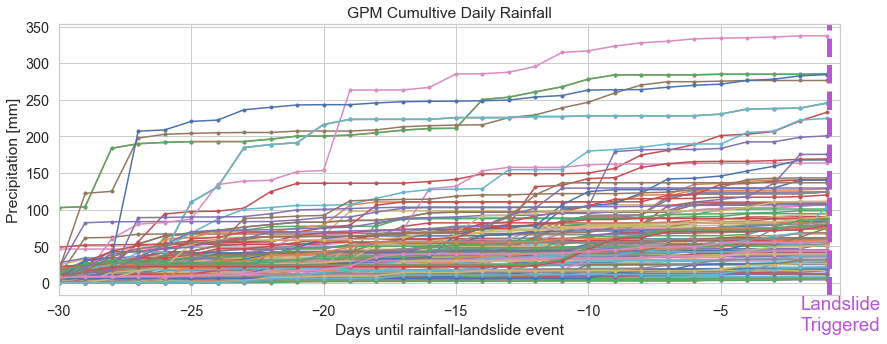

In [20]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in gpm_30days_df.groupby("landslideID"):
    ax.plot(df['days-to-landslide'], df['precip_accum'], marker='.')

#ax.invert_xaxis()
ax.axvline(x=-0.9, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)
ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days until rainfall-landslide event',
       ylabel='Precipitation [mm]',
       title='GPM Cumultive Daily Rainfall')
ax.text(-2,-65, 'Landslide\nTriggered', color='mediumorchid', fontsize='large');

### Calculated precipitation statistics

In [24]:
gpm_7days_df.head()

lon        lat landslideDate  precipitationCal  \
landslideID time                                                                
6253        2007-06-01 -105.849998  40.049999    2007-06-01          0.064783   
            2007-05-31 -105.849998  40.049999    2007-06-01          0.661531   
            2007-05-30 -105.849998  40.049999    2007-06-01          0.017648   
            2007-05-29 -105.849998  40.049999    2007-06-01          5.893072   
            2007-05-28 -105.849998  40.049999    2007-06-01          0.000000   

                        days-to-landslide  precip_accum  
landslideID time                                         
6253        2007-06-01                 -7      0.064783  
            2007-05-31                 -6      0.726314  
            2007-05-30                 -5      0.743962  
            2007-05-29                 -4      6.637034  
            2007-05-28                 -3      6.637034

In [31]:
gpm_7day_stats = gpm_7days_df.groupby('landslideID').agg({'precipitationCal': ['min', 'max', 'mean', 'median']})
gpm_7day_stats.columns = gpm_7day_stats.columns.map('_'.join)
gpm_7day_stats

gpm_30day_stats = gpm_30days_df.groupby('landslideID').agg({'precipitationCal': ['min', 'max', 'mean', 'median']})
gpm_30day_stats.columns = gpm_30day_stats.columns.map('_'.join)
gpm_30day_stats


,precipitationCal_min,precipitationCal_max,precipitationCal_mean,precipitationCal_median
landslideID,,,,
6253,0.0,5.893072,0.690755,0.300501
185,0.0,9.924062,2.237325,0.901350
238,0.0,22.166019,1.679278,0.109697
268,0.0,48.704182,2.474990,0.000000
499,0.0,1.531000,0.141167,0.001400
...,...,...,...,...
9470,0.0,29.519997,4.558664,0.852850
9486,0.0,12.765491,1.897209,0.902982
9497,0.0,4.850917,1.081562,0.247387


### Plot the distribution of the statistics

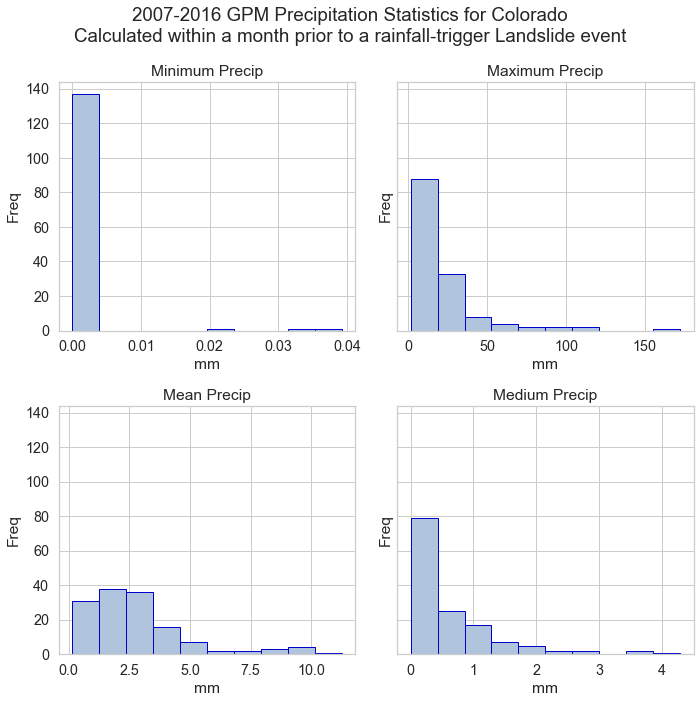

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, 
                                         figsize=(10, 10),
                                         sharey=True)
# Add overall figure title
tit1 = '2007-2016 GPM Precipitation Statistics for Colorado'
tit2 = 'Calculated within a month prior to a rainfall-trigger Landslide event'
fig.suptitle(tit1+'\n'+tit2)


# the histogram of the data
gpm_30day_stats['precipitationCal_min'].hist(ax=ax1, 
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_30day_stats['precipitationCal_max'].hist(ax=ax2,
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_30day_stats['precipitationCal_mean'].hist(ax=ax3,
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_30day_stats['precipitationCal_median'].hist(ax=ax4,
                              color='lightsteelblue', edgecolor='mediumblue')

ax1.set(xlabel='mm', ylabel='Freq',
        title='Minimum Precip');
ax2.set(xlabel='mm', ylabel='Freq',
        title='Maximum Precip');
ax3.set(xlabel='mm', ylabel='Freq',
        title='Mean Precip');
ax4.set(xlabel='mm', ylabel='Freq',
        title='Medium Precip');

fig.tight_layout()

#### Plot the 14 day histogram

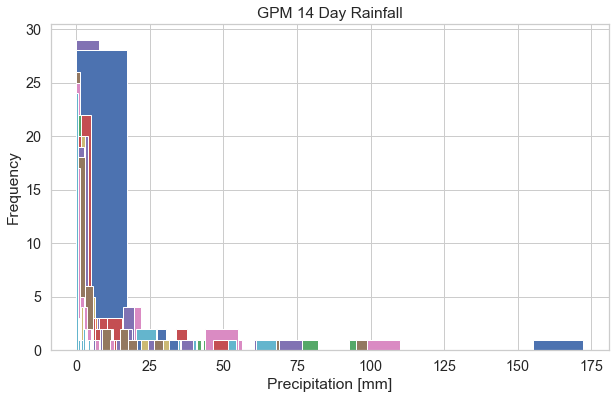

In [16]:
fig, ax = plt.subplots(figsize=(10, 6),sharex=True, sharey=True)

for id, df in gpm_30days_df.groupby("landslideID"):
    ax.hist(df.precipitationCal)

ax.set(ylabel='Frequency',
       xlabel='Precipitation [mm]',
       title='GPM 14 Day Rainfall');

#### Export to a CSV file

In [17]:
#gpm_7days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_7days.csv'))
#gpm_14days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_14days.csv'))
#gpm_30days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_30days.csv'))